# Detecting Intentional Misstatements by US Corporations

**Motivation and objective:** Predicting whether a US corporation is intentionally misstating its financial statement is a supervised binary classification problem with imbalanced class distribution. This notebook aims to find the best machine learning model and hyperparameters to achieve a higher AUC score. 

# Model Selection & Implementation

The content of this notebook is as follow:

- Dealing with missing data for test and train data set 
- Model selection and implementation
- Model hyperparameter tuning with Randomized Grid CV search 

In [4]:
#importing the relevant libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

pd.set_option('display.max_colwidth',-1)

In [5]:
# Import testing and train data that contains all variables engineered 
training = pd.read_csv('training-merged.csv')
testing = pd.read_csv('testing-merged.csv')


## Class distribution

In [6]:
per_of_restatement  =len(training[training.Restate_Int == 1])/len(training)
print('Imbalance class distribution:', per_of_restatement)


Imbalance class distribution: 0.02386117136659436


# Dealing with missing values 


### Remove all the rows with missing values in any features before variable selection

In [7]:
training.dropna(axis = 0, inplace= True)

## Variable Selection 

Based on the features identified from our exploratory data analytics, here are the variables that we will be including in our model: 

In [8]:
# variable selection here
#creat X_train, y_train, X_test 
X_train = training[['Coleman_Liau_Index', 'averageWordsPerSentence', 'FinTerms_Negative',
       'FinTerms_Positive', 'FinTerms_Litigious', 'FinTerms_ModalStrong',
       'log_total_assets', 'change_in_inventory', 'percent_soft_assets',
       'merger', 'big_n_auditor', 'tot_financing', 'ex_ante_financing',
       'restructuring', 'auop_qualified', 'auopic_no_report',
       'auopic_effective', 'auopic_adverse', 'au_9', 'ch_au', 'sic_2092',
       'sic_2253', 'sic_3524', 'sic_3569', 'sic_4013', 'sic_4512', 'sic_5122',
       'sic_5399', 'sic_6552', 'sic_8093','GOING_CONCERN']].copy()

y_train= training['Restate_Int'].copy()

X_test = testing[['Coleman_Liau_Index', 'averageWordsPerSentence', 'FinTerms_Negative',
       'FinTerms_Positive', 'FinTerms_Litigious', 'FinTerms_ModalStrong',
       'log_total_assets', 'change_in_inventory', 'percent_soft_assets',
       'merger', 'big_n_auditor', 'tot_financing', 'ex_ante_financing',
       'restructuring', 'auop_qualified', 'auopic_no_report',
       'auopic_effective', 'auopic_adverse', 'au_9', 'ch_au', 'sic_2092',
       'sic_2253', 'sic_3524', 'sic_3569', 'sic_4013', 'sic_4512', 'sic_5122',
       'sic_5399', 'sic_6552', 'sic_8093','GOING_CONCERN']]

output_gvkey = testing['Restate_Int']

### Replace all testing feature missing values: 
- if the feature is categorical, replace with most frequent value
- if the feature is numeric, replace with mean

In [9]:
# fill in all the missing values 
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)
X = pd.DataFrame(X_test)
X_test = DataFrameImputer().fit_transform(X)


In [10]:
#make sure the length of the row matches
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(output_gvkey))

X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')

14287
14287
2989
2989


# Implementation of Model 

## Algorithm 1:  Random forest

**Rational for selecting random forest: ** 
- Can be used for both continuos or categorical target prediction problem
- Adopts bagging technique to combine multiples decision trees formed from subsets of the training set to improve the overall performance of the model 
- Bagging technique ensures minimum correlation among the trees which prevents overfitting, as tree methods used on its own tends to overfit
- Good at detecting interactions between different features, but highly correlated features can mask these interactions
- Able to handle a high number of features 


# Prediction with Random Forest's Default Setting
With the default hyperparameters in Random Forest, the in sample accuracy is about 0.58 with 5 fold CV


In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


## Default hyperparameters in Random Forest

In [15]:
# create a random forest object 
clf=RandomForestClassifier()
# check the default paramater of random forest 
clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [25]:
clf=RandomForestClassifier( )

cv_scores = cross_val_score(clf, X_train, y_train, scoring = 'roc_auc', cv =5)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
#y_pred=clf.predict(X_test)

clf.fit(X_train,y_train)


Average 5-Fold CV Score: 0.5802198327632977


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

##  Hyperparameter Tuning in Random Forest with Random Search Cross Validation
**Main hyperparameters to find tune:**
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [12]:
# prepare the hyperparameters to tune 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [13]:
clf=RandomForestClassifier( )
rf_random = RandomizedSearchCV(estimator = clf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 2,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1,
                               scoring = 'roc_auc')
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 23.1min finished


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [14]:
# get the best parameter 
rf_random.best_params_

{'n_estimators': 822,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [27]:
rf_random.best_params_

{'n_estimators': 822,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [24]:
# Fit & Predict 
clf=RandomForestClassifier(n_estimators=822,
                           min_samples_split= 2,
                           min_samples_leaf=4,
                           max_features= 'sqrt',
                           max_depth= 10,
                           bootstrap= True )
clf.fit(X_train,y_train)
pred = clf.predict_proba(X_test) 
#output the result to CSV 

results_df = pd.DataFrame(data={'gvkey':testing['gvkey'], 'Restate_Int':pred[:,1].tolist()})
results_df.to_csv('rf_py.csv',index =False)

No handles with labels found to put in legend.


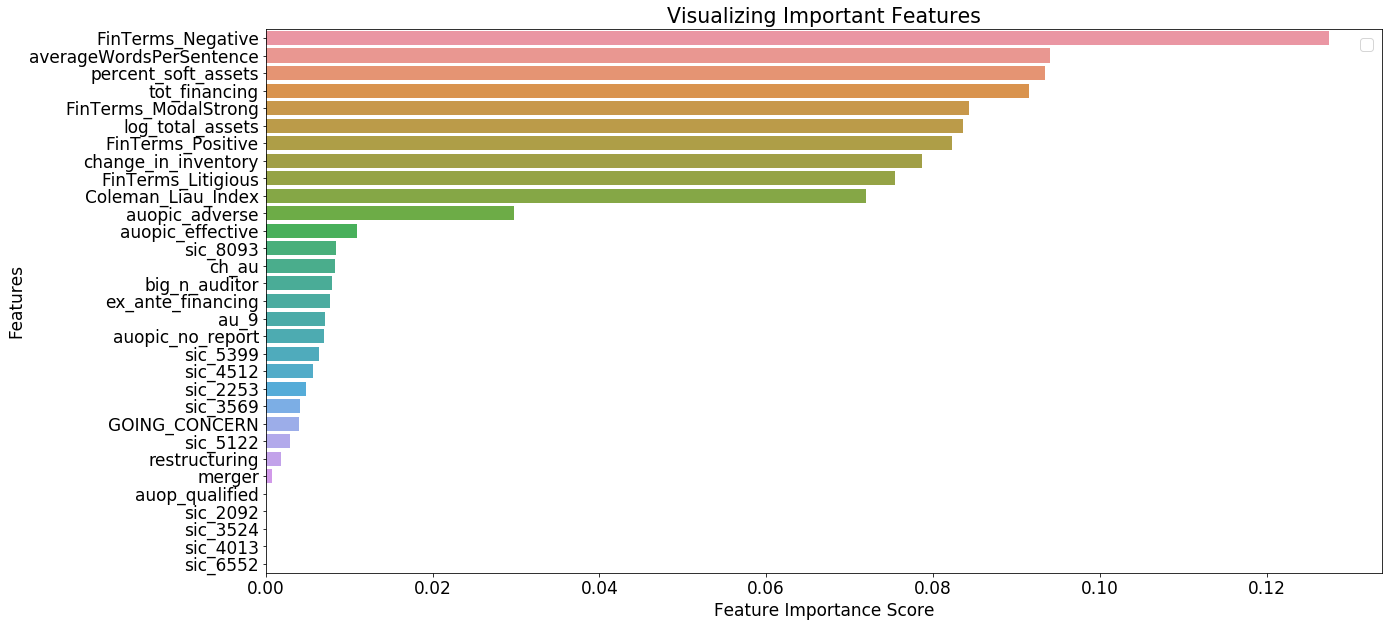

In [26]:
feature_imp = pd.Series(clf.feature_importances_,index =X_train.columns).sort_values(ascending=False)
feature_imp

plt.figure(figsize=(20,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.rcParams.update({'font.size': 17})
plt.rcParams['figure.figsize'] = [23, 20]

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()


## Algorithm 2:  Support Vector Machines

In [32]:
from sklearn.svm import SVC

# Prediction with SVC's Default Setting
With the default hyperparameters in SCV, the in sample accuracy is about 0.48 with 5 fold CV

**Rational for selecting random forest: ** 
- One of the most robust binary classifcaiont models that is able to take in a large number of variales with high sparsity
- Robust at dealing with datasets with imbalanced class frequencies

In [34]:
# create a random forest object 
clf = SVC()
# check the default paramater of random forest 
clf.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [13]:
clf = SVC(kernel = 'rbf') 
cv_results = cross_val_score(clf , X_train, y_train, cv =5, scoring = 'roc_auc')
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))


Average 5-Fold CV Score: 0.4800514951779018


##  Hyperparameter Tuning in SVC with Random Search Cross Validation


**The hyperparameter to fine tune in SVC are:** 
- Type of kernel 
- gamme = for non linear hyperplane
- C = penality parameter of the error term, tradeoff bet smooth decision boundary and classifying the traning points correctly
- Degree= degree of the polynomial used to find the hyperplane to split the data

In [54]:
# create the param for grid search 
gamma = [0.1,1,10,100 ]
C = [0.1,1,10,100]
degree = [0,1,2,3,4,5,6] #when degree is 1 , the kernel is same as linear 

param_grid = dict(gamma=gamma, C=C, degree= degree)
print(param_grid)


{'gamma': [0.1, 1, 10, 100], 'C': [0.1, 1, 10, 100], 'degree': [0, 1, 2, 3, 4, 5, 6]}


In [55]:
import time 

# initiate a SVC obj
clf = SVC() 
# Grid search 
grid = RandomizedSearchCV(estimator=clf, 
                          param_distributions = param_grid,
                          n_iter = 50,
                          cv = 2,
                          verbose=2,
                          random_state=42,
                          n_jobs = -1,
                          scoring = 'roc_auc') #no job to run in parallel, -1 means using all processor

start_time = time.time()
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.4min finished


Best: 0.599750 using {'gamma': 10, 'degree': 1, 'C': 100}
Execution time: 484.8979494571686 ms


The best parameter selected is gamma of 10, degree of 1 and C of 100. These settings allows SVC to be non linear at fitting the training data set, penalizes error term by 100 which may lead to overfitting and uses 1 degree of polynomial used to find the hyperplane to split the data.

In [56]:
#kfold = KFold(n_splits=3, random_state=7)

clf = SVC( gamma =10 ,  C= 100 ,probability =True, degree =1 , verbose = True) 
clf.fit(X_train, y_train)


cv_results = cross_val_score(clf , X_train, y_train, cv =5, scoring = 'roc_auc')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

output_test = clf.predict_proba(X_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Average 5-Fold CV Score: 0.5852981260419671


In [57]:
output_test[:,1]

array([0.01019706, 0.02365011, 0.02375276, ..., 0.0244432 , 0.02432189,
       0.02442388])

In [58]:
# output the file 
results_df = pd.DataFrame(data={'gvkey':testing['gvkey'], 'Restate_Int':output_test[:,1]})
results_df.to_csv('SVM_funetune_prob.csv', index=False)

References: 
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769
- https://www.datacamp.com/community/tutorials/random-forests-classifier-python
- https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf